# Analisi Esplorativa dei Dati (EDA)
## Dataset: Fitness Tracking - Experience Level Classification

---

**Autore:** Alessandro Ambrosio  
**Versione:** 1.0

---

### Obiettivo dello Studio

Questo notebook presenta un'analisi esplorativa completa del dataset sintetico generato per la classificazione del livello di esperienza degli utenti di fitness tracking.

---

### Struttura del Notebook

1. Setup e Inizializzazione
2. Caricamento Dataset
3. Classificazione Feature
4. Analisi Target
5. Qualità Dati
6. Analisi Univariata
7. Analisi Bivariata
8. Rilevamento Outliers
9. Analisi Multivariata
10. Analisi Correlazioni
11. Analisi Comportamentale
12. Feature Temporali
13. Analisi per Esercizio
14. Conclusioni


---

# Classificazione Feature

## Feature Osservabili (Usabili in Produzione)

| Feature | Fonte | Descrizione |
|---------|-------|-------------|
| load_done_kg | workout_sets | Carico sollevato (kg) |
| reps_done | workout_sets | Ripetizioni eseguite |
| rpe_done | workout_sets | RPE auto-riportato |
| workout_status | workouts | Sessione done/skipped |
| exercise_id | workout_sets | Tipo esercizio |
| session_tag | workouts | Split day |
| weekly_freq_declared | users | Frequenza dichiarata |
| split_type | users | Tipo split |
| date | workouts | Timestamp |

## Feature Interne (NON Osservabili)

| Feature | Motivo Esclusione |
|---------|-------------------|
| experience_latent | Parametro latente |
| alpha_adapt | Parametro fisiologico |
| k_detraining | Parametro detraining |
| obs_noise | Rumore simulato |
| resilience | Capacità latente |
| fatigue_sens | Sensibilità latente |
| rpe_report_bias | Bias percezione |

## Feature Piano (Rischio Leakage)

| Feature | Motivo Esclusione |
|---------|-------------------|
| load_intended_kg | Prescrizione coach |
| sets_planned | Piano allenamento |
| reps_target_avg | Target prescritto |
| rir_target | RIR prescritto |


---

# SEZIONE 1: Setup e Inizializzazione

---


In [ ]:
# -*- coding: utf-8 -*-
"""
═══════════════════════════════════════════════════════════════════════════
    ANALISI ESPLORATIVA DEI DATI (EDA)
    Dataset: Fitness Tracking - Experience Level Classification
═══════════════════════════════════════════════════════════════════════════

Autore: [Alessandro Ambrosio]
Versione: 1.0

OBIETTIVO:
    Analisi esplorativa completa del dataset grezzo per:
    - Validare qualità e completezza dei dati
    - Identificare pattern e relazioni tra variabili
    - Comprendere distribuzione del target (experience_label)
    - Selezionare feature rilevanti per modellazione

STRUTTURA:
    1. Setup e Caricamento Dati
    2. Panoramica Dataset
    3. Analisi Target
    4. Qualità Dati (Missing, Outliers)
    5. Analisi Univariata
    6. Analisi Bivariata
    7. Analisi Multivariata
    8. Correlazioni
    9. Analisi Comportamentale
    10. Conclusioni

NOTE:
    - Feature osservabili vs interne (non utilizzabili in produzione)
    - Focus su dati grezzi (no aggregazioni)
═══════════════════════════════════════════════════════════════════════════
"""

# ═══════════════════════════════════════════════════════════════════════════
# 1. SETUP E IMPORTAZIONI
# ═══════════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'

# Palette colori per livelli esperienza
LEVEL_COLORS = {
    'Beginner': '#2ecc71',
    'Intermediate': '#3498db',
    'Advanced': '#e74c3c'
}

print("="*80)
print("ANALISI ESPLORATIVA DEI DATI (EDA) - INIZIALIZZAZIONE COMPLETATA")
print("="*80)



ANALISI ESPLORATIVA DEI DATI (EDA) - INIZIALIZZAZIONE COMPLETATA


---

# SEZIONE 2: Caricamento Dataset

---


In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 2. CARICAMENTO DATI
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 1: CARICAMENTO DATASET")
print("="*80)

# Caricamento CSV
df_users = pd.read_csv('users.csv')
df_sets = pd.read_csv('workout_sets.csv')
df_workouts = pd.read_csv('workouts.csv')
df_sessions = pd.read_csv('sessions.csv')
df_exercises = pd.read_csv('exercises.csv')

# Pulizia colonne duplicate
df_sets = df_sets.drop(columns=['experience_label'], errors='ignore')
df_workouts = df_workouts.drop(columns=['experience_label'], errors='ignore')

# Panoramica dimensioni
datasets_info = pd.DataFrame({
    'Dataset': ['users', 'workout_sets', 'workouts', 'sessions', 'exercises'],
    'Righe': [len(df_users), len(df_sets), len(df_workouts),
              len(df_sessions), len(df_exercises)],
    'Colonne': [len(df_users.columns), len(df_sets.columns),
                len(df_workouts.columns), len(df_sessions.columns),
                len(df_exercises.columns)],
    'Size_MB': [
        df_users.memory_usage(deep=True).sum() / 1024**2,
        df_sets.memory_usage(deep=True).sum() / 1024**2,
        df_workouts.memory_usage(deep=True).sum() / 1024**2,
        df_sessions.memory_usage(deep=True).sum() / 1024**2,
        df_exercises.memory_usage(deep=True).sum() / 1024**2
    ]
})

print("\nDimensioni Dataset:")
print(datasets_info.to_string(index=False))
print(f"\nMemoria totale: {datasets_info['Size_MB'].sum():.2f} MB")




SEZIONE 1: CARICAMENTO DATASET

Dimensioni Dataset:
     Dataset  Righe  Colonne   Size_MB
       users    400       16  0.144674
workout_sets 128333       16 37.267952
    workouts  19772        9  4.060329
    sessions  17552        8  2.711365
   exercises     12        8  0.004787

Memoria totale: 44.19 MB


---

# SEZIONE 3: Inventario Feature

---


In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 3. CLASSIFICAZIONE FEATURE (OSSERVABILI VS INTERNE)
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 2: CLASSIFICAZIONE FEATURE")
print("="*80)

# Feature osservabili (utilizzabili in produzione)
OBSERVABLE_FEATURES = {
    'users': ['userid', 'experience_label', 'weekly_freq_declared', 'split_type'],
    'workout_sets': ['userid', 'workoutid', 'exercise_id', 'set_index',
                     'load_done_kg', 'reps_done', 'rpe_done'],
    'workouts': ['userid', 'workoutid', 'date', 'session_tag', 'workout_status']
}

# Feature interne (parametri generazione, non osservabili)
INTERNAL_FEATURES = {
    'users': ['experience_latent', 'alpha_adapt', 'k_detraining',
              'obs_noise', 'resilience', 'fatigue_sens', 'rpe_report_bias'],
    'workouts': ['z_skip', 'p_skip', 'fatigue_term']
}

# Feature piano (rischio leakage)
PLAN_FEATURES = ['load_intended_kg', 'sets_planned', 'reps_target_avg',
                 'reps_min', 'reps_max', 'rir_target', 'gap_adherence_score']

print("\nFEATURE OSSERVABILI (utilizzabili):")
for dataset, features in OBSERVABLE_FEATURES.items():
    print(f"\n  {dataset}:")
    for feat in features:
        print(f"    - {feat}")

print("\nFEATURE INTERNE (solo generazione, escluse):")
for dataset, features in INTERNAL_FEATURES.items():
    print(f"\n  {dataset}:")
    for feat in features:
        print(f"    - {feat}")

print("\nFEATURE PIANO ALLENAMENTO (rischio leakage, escluse):")
print(f"  workout_sets:")
for feat in PLAN_FEATURES:
    if feat in df_sets.columns:
        print(f"    - {feat}")




SEZIONE 2: CLASSIFICAZIONE FEATURE

FEATURE OSSERVABILI (utilizzabili):

  users:
    - userid
    - experience_label
    - weekly_freq_declared
    - split_type

  workout_sets:
    - userid
    - workoutid
    - exercise_id
    - set_index
    - load_done_kg
    - reps_done
    - rpe_done

  workouts:
    - userid
    - workoutid
    - date
    - session_tag
    - workout_status

FEATURE INTERNE (solo generazione, escluse):

  users:
    - experience_latent
    - alpha_adapt
    - k_detraining
    - obs_noise
    - resilience
    - fatigue_sens
    - rpe_report_bias

  workouts:
    - z_skip
    - p_skip
    - fatigue_term

FEATURE PIANO ALLENAMENTO (rischio leakage, escluse):
  workout_sets:
    - load_intended_kg
    - rir_target


---

# SEZIONE 4: Analisi Target

---



SEZIONE 3: ANALISI VARIABILE TARGET (experience_label)

Distribuzione Target:
     Livello  Frequenza  Percentuale
Intermediate        219        54.75
    Beginner        136        34.00
    Advanced         45        11.25

Imbalance Ratio (max/min): 4.87
Status: Dataset sbilanciato - considerare stratified sampling


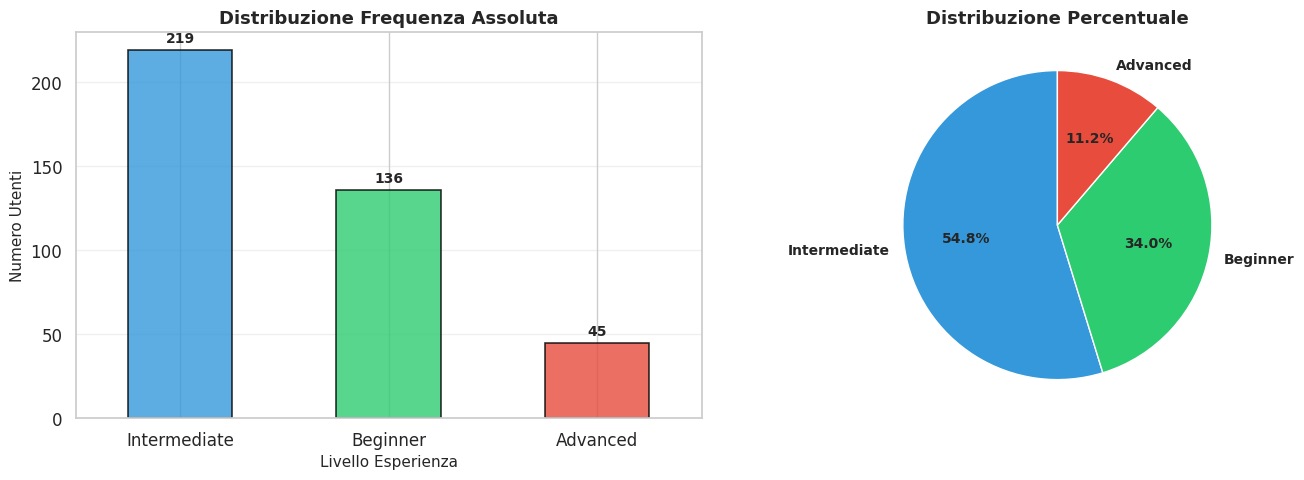

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 4. ANALISI TARGET
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 3: ANALISI VARIABILE TARGET (experience_label)")
print("="*80)

target_counts = df_users['experience_label'].value_counts()
target_props = df_users['experience_label'].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Livello': target_counts.index,
    'Frequenza': target_counts.values,
    'Percentuale': target_props.values
})

print("\nDistribuzione Target:")
print(target_summary.to_string(index=False))

# Imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio < 3:
    print("Status: Dataset bilanciato (ratio < 3)")
else:
    print("Status: Dataset sbilanciato - considerare stratified sampling")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
target_counts.plot(kind='bar', ax=axes[0],
                   color=[LEVEL_COLORS[x] for x in target_counts.index],
                   alpha=0.8, edgecolor='black', linewidth=1.2)
axes[0].set_title('Distribuzione Frequenza Assoluta', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Livello Esperienza', fontsize=11)
axes[0].set_ylabel('Numero Utenti', fontsize=11)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + target_counts.max()*0.02, str(v),
                ha='center', fontsize=10, fontweight='bold')

# Pie chart
axes[1].pie(target_props.values, labels=target_props.index,
           colors=[LEVEL_COLORS[x] for x in target_props.index],
           autopct='%1.1f%%', startangle=90,
           textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Distribuzione Percentuale', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()



---

# SEZIONE 5: Qualità Dati - Missing Values

---


In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 5. QUALITA' DATI: MISSING VALUES
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 4: ANALISI MISSING VALUES")
print("="*80)

def analyze_missing(df, name):
    """Analizza missing values in un dataframe"""
    missing = df.isna().sum()
    missing = missing[missing > 0].sort_values(ascending=False)

    if len(missing) == 0:
        print(f"\n{name}: Nessun valore mancante")
        return None

    missing_df = pd.DataFrame({
        'Colonna': missing.index,
        'Missing_Count': missing.values,
        'Missing_Pct': (missing.values / len(df) * 100).round(2)
    })

    print(f"\n{name}:")
    print(missing_df.to_string(index=False))
    return missing_df

# Analisi per ogni dataset
for name, df in [('users', df_users), ('workout_sets', df_sets),
                 ('workouts', df_workouts), ('sessions', df_sessions)]:
    analyze_missing(df, name)

print("\nNota: Missing values simulati realisticamente (sensor failures, dati non registrati)")





SEZIONE 4: ANALISI MISSING VALUES

users: Nessun valore mancante

workout_sets:
         Colonna  Missing_Count  Missing_Pct
        feedback         122041         95.1
    load_done_kg           1284          1.0
          userid              1          0.0
      sessiontag              1          0.0
      exerciseid              1          0.0
            date              1          0.0
 week_index_user              1          0.0
     reps_target              1          0.0
       set_index              1          0.0
load_intended_kg              1          0.0
       reps_done              1          0.0
        rpe_done              1          0.0
rest_planned_sec              1          0.0
      rir_target              1          0.0
       workoutid              1          0.0

workouts: Nessun valore mancante

sessions: Nessun valore mancante

Nota: Missing values simulati realisticamente (sensor failures, dati non registrati)


---

# SEZIONE 6: Analisi Univariata

---



SEZIONE 5: ANALISI UNIVARIATA - DISTRIBUZIONE FEATURE

Statistiche Descrittive Feature Performance:
                 count   mean    std   min    25%   50%   75%     max  skew  kurtosis
load_done_kg  127049.0  44.07  18.30  10.5  29.75  41.5  55.0  162.25  0.96      1.31
reps_done     128332.0   9.10   3.61   1.0   6.00   9.0  12.0   22.00  0.21     -0.37
rpe_done      128332.0   4.40   0.71   1.0   4.00   4.5   5.0    8.00 -0.04      0.13
set_index     128332.0   2.64   1.49   1.0   1.00   2.0   4.0    9.00  0.87      0.40


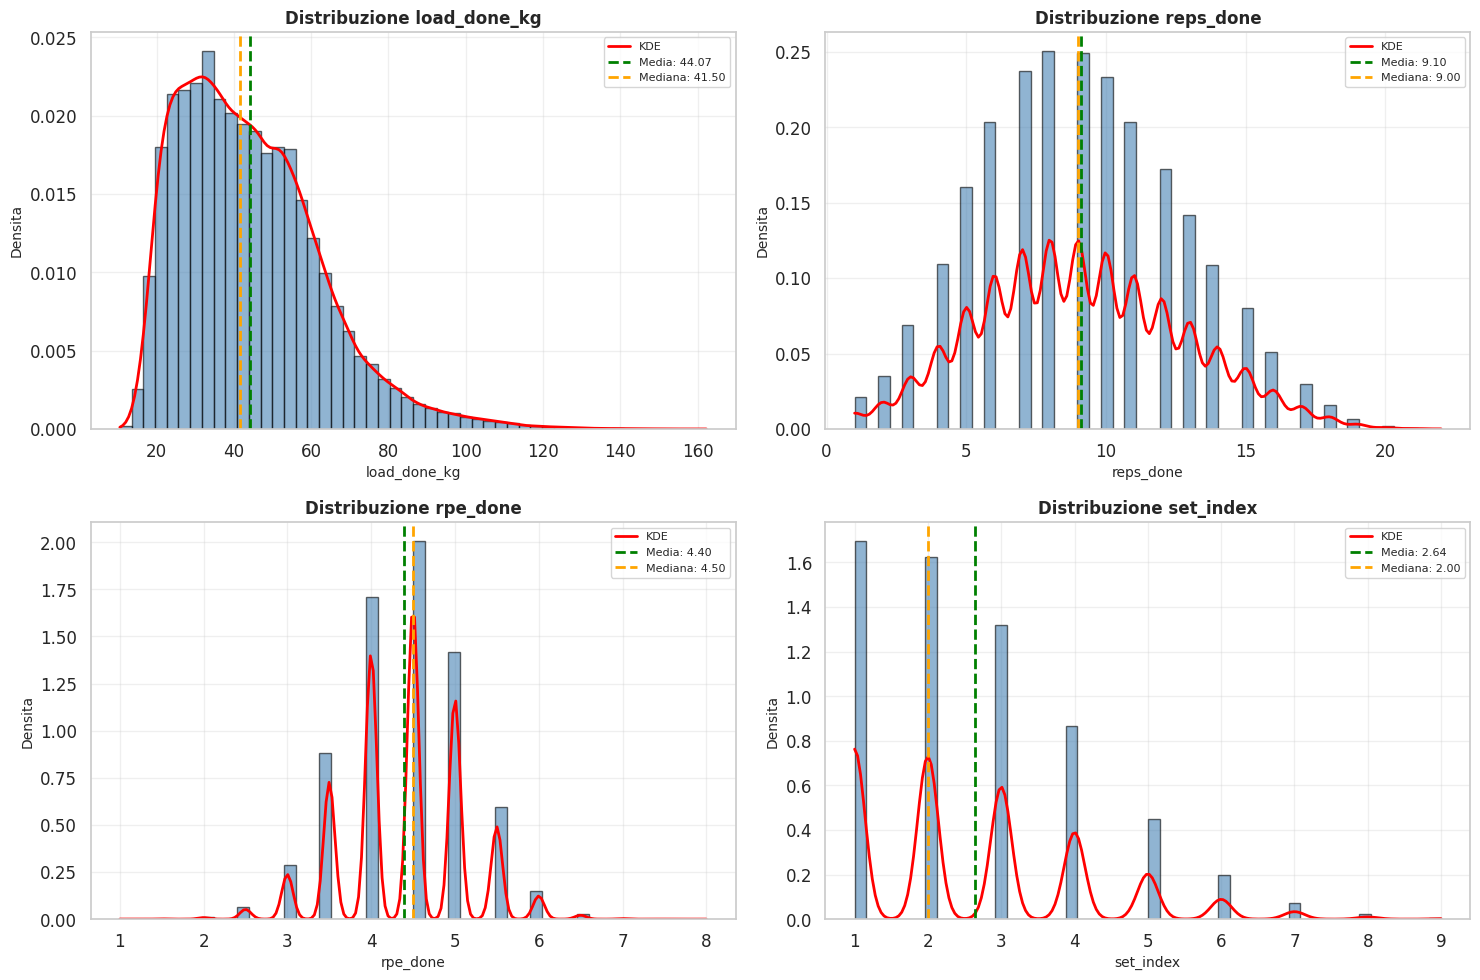

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 6. ANALISI UNIVARIATA - FEATURE NUMERICHE
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 5: ANALISI UNIVARIATA - DISTRIBUZIONE FEATURE")
print("="*80)

# Merge per analisi
df_analysis = df_sets.merge(
    df_users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

# Feature performance osservabili
performance_features = ['load_done_kg', 'reps_done', 'rpe_done', 'set_index']

# Statistiche descrittive
print("\nStatistiche Descrittive Feature Performance:")
stats_summary = df_analysis[performance_features].describe().T
stats_summary['skew'] = df_analysis[performance_features].skew()
stats_summary['kurtosis'] = df_analysis[performance_features].kurtosis()
print(stats_summary.round(2).to_string())

# Visualizzazione distribuzioni
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(performance_features):
    ax = axes[i]

    # Istogramma + KDE
    data = df_analysis[feat].dropna()
    ax.hist(data, bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)

    # Kernel Density Estimation
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

    # Media e mediana
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')

    ax.set_title(f'Distribuzione {feat}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feat, fontsize=10)
    ax.set_ylabel('Densita', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

# SEZIONE 7: Analisi Bivariata

---



SEZIONE 6: ANALISI BIVARIATA - FEATURE PER LIVELLO ESPERIENZA

LOAD_DONE_KG per Livello:
                    count   mean    std    min    25%    50%    75%     max
experience_label                                                           
Advanced          17544.0  70.27  18.04  29.75  57.00  67.25  80.75  162.25
Beginner          42030.0  26.72   6.08  10.50  22.00  26.25  30.75   59.50
Intermediate      67475.0  48.06  11.90  18.25  39.25  46.75  55.50  118.00
ANOVA: F-statistic = 97340.75, p-value = 0.0000
Conclusione: Differenze statisticamente significative tra livelli (p < 0.05)

REPS_DONE per Livello:
                    count  mean   std  min  25%  50%   75%   max
experience_label                                                
Advanced          17736.0  8.91  3.56  1.0  6.0  9.0  11.0  22.0
Beginner          42431.0  9.32  3.67  1.0  7.0  9.0  12.0  22.0
Intermediate      68165.0  9.01  3.58  1.0  6.0  9.0  11.0  22.0
ANOVA: F-statistic = 127.75, p-value = 0.0000
Conclusion

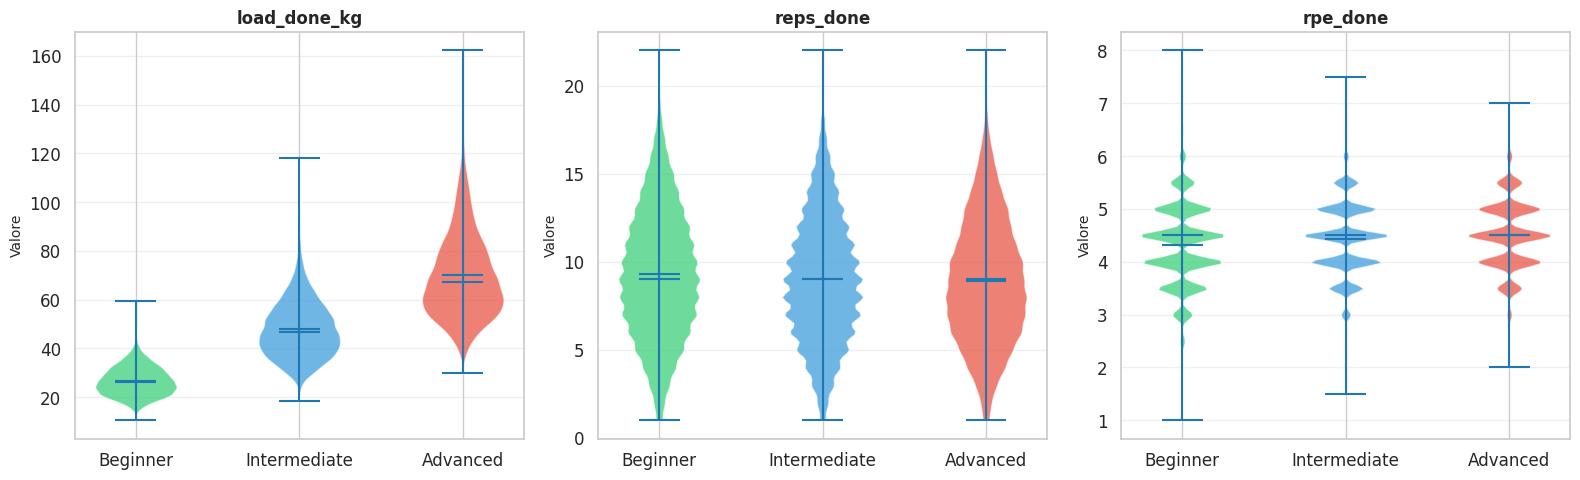

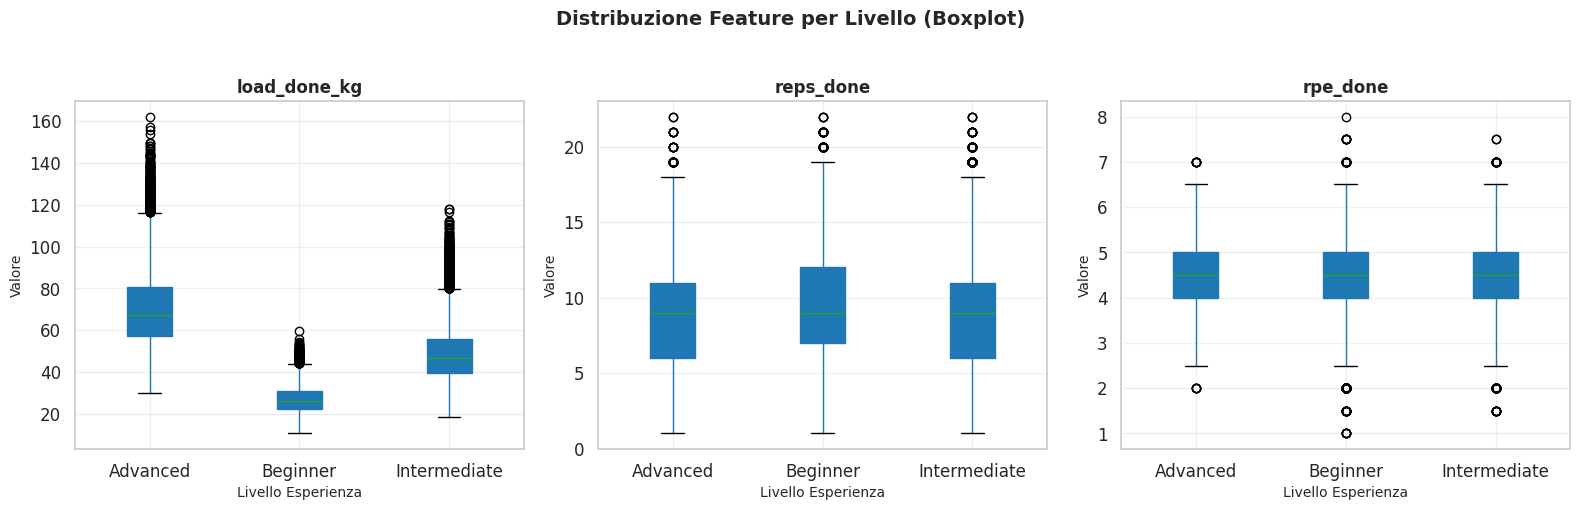

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 7. ANALISI BIVARIATA - FEATURE vs TARGET
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 6: ANALISI BIVARIATA - FEATURE PER LIVELLO ESPERIENZA")
print("="*80)

# Statistiche per livello
for feat in ['load_done_kg', 'reps_done', 'rpe_done']:
    print(f"\n{feat.upper()} per Livello:")
    stats_by_level = df_analysis.groupby('experience_label')[feat].describe()
    print(stats_by_level.round(2).to_string())

    # Test ANOVA
    groups = [df_analysis[df_analysis['experience_label'] == level][feat].dropna()
              for level in ['Beginner', 'Intermediate', 'Advanced']]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Conclusione: Differenze statisticamente significative tra livelli (p < 0.05)")
    else:
        print("Conclusione: Differenze NON significative (p >= 0.05)")

# Violin Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, feat in enumerate(['load_done_kg', 'reps_done', 'rpe_done']):
    ax = axes[i]

    # Violin plot con boxplot interno
    parts = ax.violinplot(
        [df_analysis[df_analysis['experience_label'] == level][feat].dropna()
         for level in ['Beginner', 'Intermediate', 'Advanced']],
        positions=[0, 1, 2],
        showmeans=True,
        showmedians=True
    )

    # Colorazione
    for j, pc in enumerate(parts['bodies']):
        level = ['Beginner', 'Intermediate', 'Advanced'][j]
        pc.set_facecolor(LEVEL_COLORS[level])
        pc.set_alpha(0.7)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Beginner', 'Intermediate', 'Advanced'], rotation=0)
    ax.set_title(f'{feat}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valore', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Box Plot comparativo
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, feat in enumerate(['load_done_kg', 'reps_done', 'rpe_done']):
    ax = axes[i]

    df_analysis.boxplot(column=feat, by='experience_label', ax=ax,
                        patch_artist=True, showfliers=True)

    ax.set_title(f'{feat}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Livello Esperienza', fontsize=10)
    ax.set_ylabel('Valore', fontsize=10)
    ax.get_figure().suptitle('')
    ax.grid(alpha=0.3)

plt.suptitle('Distribuzione Feature per Livello (Boxplot)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



---

# SEZIONE 8: Rilevamento Outliers

---



SEZIONE 7: ANALISI OUTLIERS (Metodo IQR)

Risultati Analisi Outliers:
     Feature    Q1   Q3   IQR  Lower_Bound  Upper_Bound  Min    Max  Outliers_Count  Outliers_Pct
load_done_kg 29.75 55.0 25.25        -8.12        92.88 10.5 162.25            2208          1.74
   reps_done  6.00 12.0  6.00        -3.00        21.00  1.0  22.00               8          0.01
    rpe_done  4.00  5.0  1.00         2.50         6.50  1.0   8.00             270          0.21


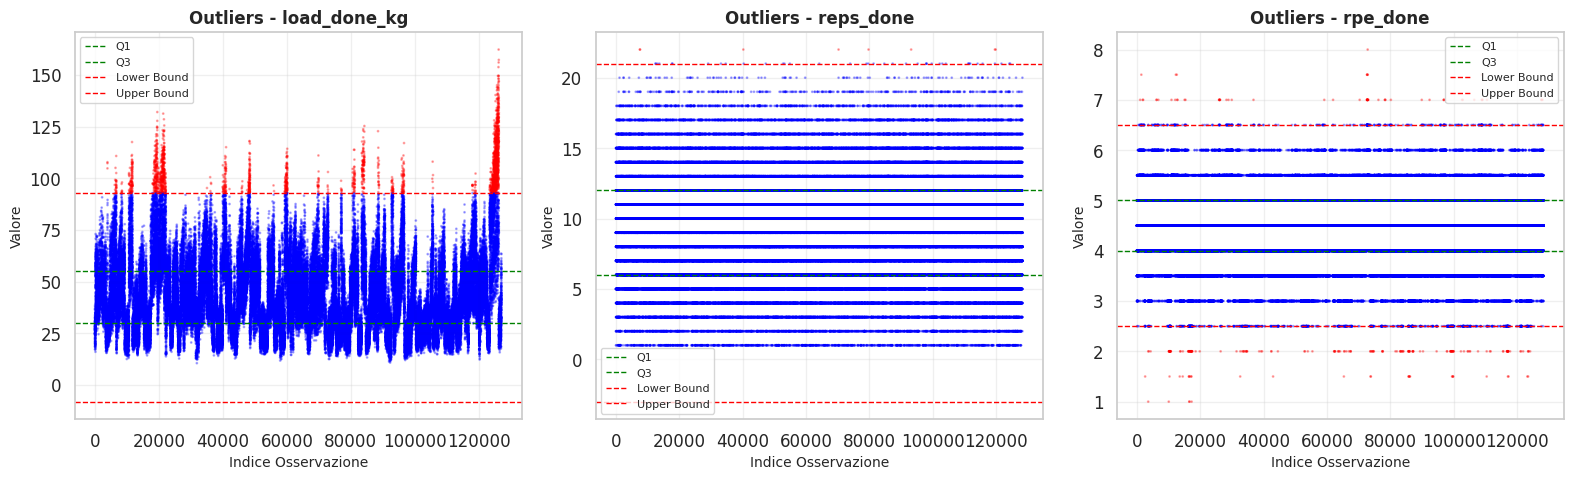

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 8. OUTLIER DETECTION
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 7: ANALISI OUTLIERS (Metodo IQR)")
print("="*80)

def detect_outliers_iqr(series, name):
    """Rileva outliers con metodo IQR"""
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (s < lower_bound) | (s > upper_bound)
    outlier_count = outliers.sum()
    outlier_pct = (outlier_count / len(s)) * 100

    return {
        'Feature': name,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min': s.min(),
        'Max': s.max(),
        'Outliers_Count': outlier_count,
        'Outliers_Pct': outlier_pct
    }

outlier_results = []
for feat in ['load_done_kg', 'reps_done', 'rpe_done']:
    result = detect_outliers_iqr(df_analysis[feat], feat)
    outlier_results.append(result)

outlier_df = pd.DataFrame(outlier_results)
print("\nRisultati Analisi Outliers:")
print(outlier_df.round(2).to_string(index=False))

# Visualizzazione outliers
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, feat in enumerate(['load_done_kg', 'reps_done', 'rpe_done']):
    ax = axes[i]

    data = df_analysis[feat].dropna()
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

    # Scatter plot
    outliers = (data < lower) | (data > upper)
    ax.scatter(range(len(data)), data, c=['red' if o else 'blue' for o in outliers],
               alpha=0.3, s=1)

    # Linee IQR
    ax.axhline(q1, color='green', linestyle='--', linewidth=1, label='Q1')
    ax.axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3')
    ax.axhline(lower, color='red', linestyle='--', linewidth=1, label='Lower Bound')
    ax.axhline(upper, color='red', linestyle='--', linewidth=1, label='Upper Bound')

    ax.set_title(f'Outliers - {feat}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Indice Osservazione', fontsize=10)
    ax.set_ylabel('Valore', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()




---

# SEZIONE 9: Analisi Multivariata

---



SEZIONE 8: ANALISI MULTIVARIATA - RELAZIONI TRA FEATURE

Generazione Pairplot (può richiedere tempo)...


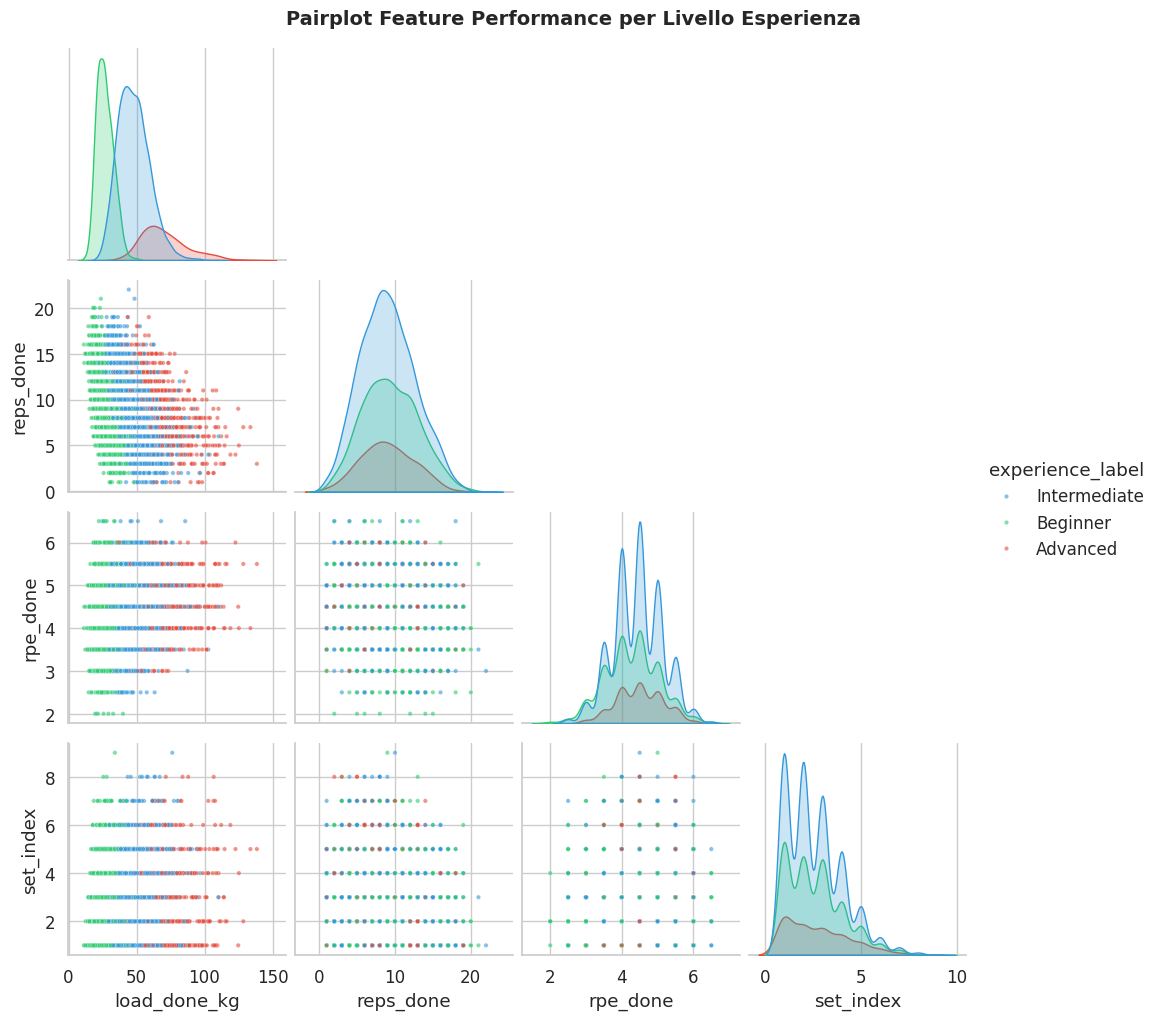

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 9. ANALISI MULTIVARIATA - PAIRPLOT
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 8: ANALISI MULTIVARIATA - RELAZIONI TRA FEATURE")
print("="*80)

# Campionamento per pairplot (troppi dati rallentano il plot)
df_sample = df_analysis.sample(n=min(5000, len(df_analysis)), random_state=42)

# Pairplot
print("\nGenerazione Pairplot (può richiedere tempo)...")
pairplot_features = ['load_done_kg', 'reps_done', 'rpe_done', 'set_index', 'experience_label']
g = sns.pairplot(df_sample[pairplot_features],
                 hue='experience_label',
                 palette=LEVEL_COLORS,
                 diag_kind='kde',
                 plot_kws={'alpha': 0.6, 's': 10},
                 corner=True)
g.fig.suptitle('Pairplot Feature Performance per Livello Esperienza',
               y=1.02, fontsize=14, fontweight='bold')
plt.show()


---

# SEZIONE 10: Analisi Correlazioni

---



SEZIONE 9: ANALISI CORRELAZIONI

Aggregazione feature per utente (per analisi correlazione con target)...

Matrice di Correlazione (Pearson):
                load_mean  load_max  load_std  reps_mean  reps_total  rpe_mean  rpe_std  sets_total  target_encoded
load_mean           1.000     0.951     0.889     -0.248       0.190     0.121   -0.578       0.216           0.967
load_max            0.951     1.000     0.949     -0.235       0.364     0.124   -0.515       0.388           0.900
load_std            0.889     0.949     1.000     -0.236       0.315     0.101   -0.509       0.341           0.828
reps_mean          -0.248    -0.235    -0.236      1.000      -0.062     0.018    0.055      -0.130          -0.172
reps_total          0.190     0.364     0.315     -0.062       1.000    -0.091   -0.005       0.996           0.077
rpe_mean            0.121     0.124     0.101      0.018      -0.091     1.000   -0.079      -0.087           0.113
rpe_std            -0.578    -0.515    -0.509

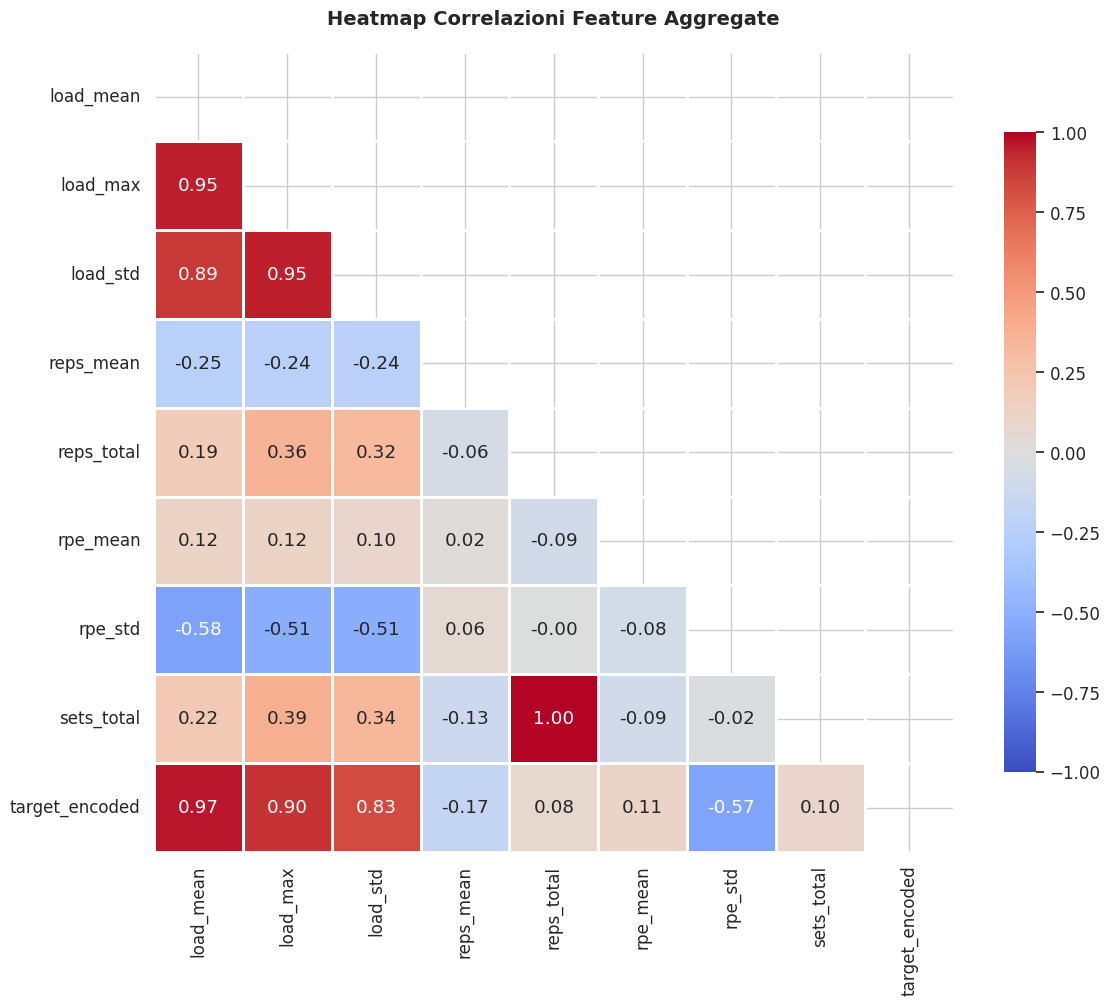


Correlazioni con Target (experience_label encodato):
load_mean     0.967
load_max      0.900
load_std      0.828
rpe_mean      0.113
sets_total    0.097
reps_total    0.077
reps_mean    -0.172
rpe_std      -0.566


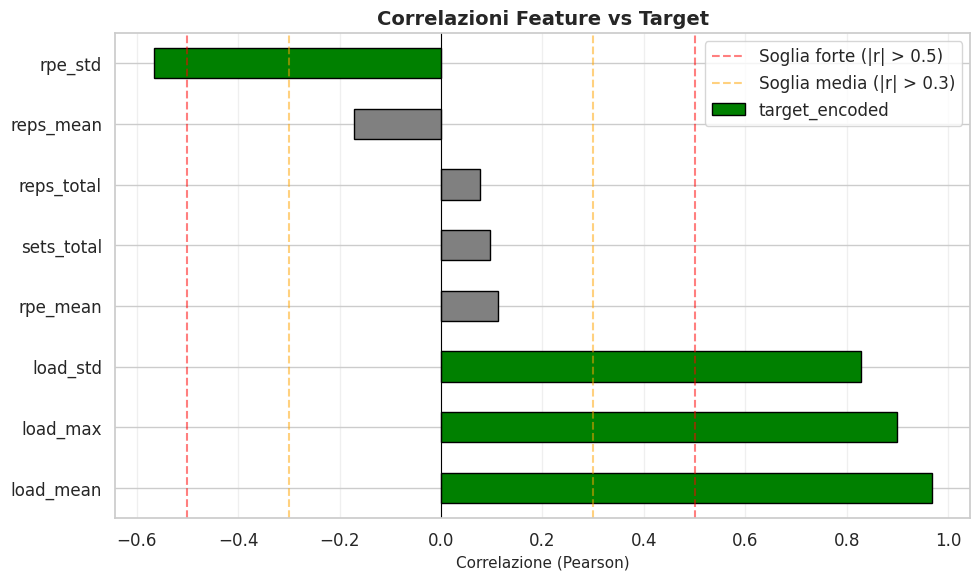

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 10. ANALISI CORRELAZIONI
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 9: ANALISI CORRELAZIONI")
print("="*80)

# Aggregazione per utente (necessaria per correlazioni con target)
print("\nAggregazione feature per utente (per analisi correlazione con target)...")

user_agg = df_analysis.groupby('userid').agg({
    'load_done_kg': ['mean', 'max', 'std'],
    'reps_done': ['mean', 'sum'],
    'rpe_done': ['mean', 'std'],
    'set_index': 'count'
}).reset_index()

user_agg.columns = ['userid', 'load_mean', 'load_max', 'load_std',
                    'reps_mean', 'reps_total', 'rpe_mean', 'rpe_std', 'sets_total']

# Merge con target
user_agg = user_agg.merge(df_users[['userid', 'experience_label']], on='userid')

# Encoding target
experience_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
user_agg['target_encoded'] = user_agg['experience_label'].map(experience_map)

# Matrice correlazione
feature_cols = ['load_mean', 'load_max', 'load_std', 'reps_mean',
                'reps_total', 'rpe_mean', 'rpe_std', 'sets_total', 'target_encoded']
corr_matrix = user_agg[feature_cols].corr()

print("\nMatrice di Correlazione (Pearson):")
print(corr_matrix.round(3).to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Heatmap Correlazioni Feature Aggregate',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlazioni con target
corr_with_target = corr_matrix['target_encoded'].drop('target_encoded').sort_values(ascending=False)
print("\nCorrelazioni con Target (experience_label encodato):")
print(corr_with_target.round(3).to_string())

# Bar plot correlazioni
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0.5 else 'orange' if x > 0.3 else 'gray'
          for x in corr_with_target.abs()]
corr_with_target.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_title('Correlazioni Feature vs Target', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlazione (Pearson)', fontsize=11)
ax.axvline(0, color='black', linewidth=0.8)
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Soglia forte (|r| > 0.5)')
ax.axvline(-0.5, color='red', linestyle='--', alpha=0.5)
ax.axvline(0.3, color='orange', linestyle='--', alpha=0.5, label='Soglia media (|r| > 0.3)')
ax.axvline(-0.3, color='orange', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



---

# SEZIONE 11: Analisi Comportamentale

---



SEZIONE 10: ANALISI COMPORTAMENTALE - WORKOUT STATUS

Distribuzione Workout Status (globale):
 Status  Frequenza  Percentuale
   done      17552    88.772001
skipped       2220    11.227999

Skip Rate per Livello Esperienza:
     Livello  Skip_Rate_%
    Beginner    14.499618
Intermediate     9.914187
    Advanced     8.139023

Test Chi-quadrato Indipendenza:
  Chi2 = 111.01, p-value = 0.0000, df = 2
  Conclusione: Status e livello esperienza sono DIPENDENTI (p < 0.05)


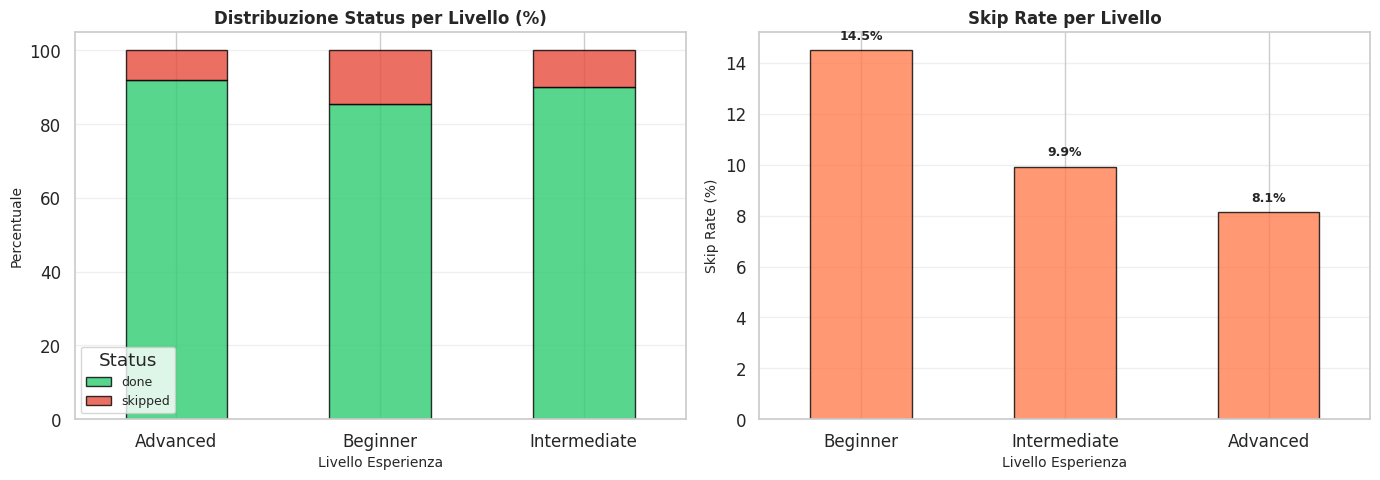

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 11. ANALISI COMPORTAMENTALE - WORKOUT STATUS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 10: ANALISI COMPORTAMENTALE - WORKOUT STATUS")
print("="*80)

# Merge workouts + users
df_wk_analysis = df_workouts.merge(
    df_users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

# Distribuzione globale
status_counts = df_wk_analysis['workout_status'].value_counts()
status_props = df_wk_analysis['workout_status'].value_counts(normalize=True) * 100

print("\nDistribuzione Workout Status (globale):")
status_summary = pd.DataFrame({
    'Status': status_counts.index,
    'Frequenza': status_counts.values,
    'Percentuale': status_props.values
})
print(status_summary.to_string(index=False))

# Skip rate per livello
skip_by_level = df_wk_analysis.groupby('experience_label')['workout_status'].apply(
    lambda x: (x == 'skipped').mean() * 100
).sort_values(ascending=False)

print("\nSkip Rate per Livello Esperienza:")
skip_summary = pd.DataFrame({
    'Livello': skip_by_level.index,
    'Skip_Rate_%': skip_by_level.values
})
print(skip_summary.to_string(index=False))

# Test Chi-quadrato
contingency_table = pd.crosstab(df_wk_analysis['experience_label'],
                                 df_wk_analysis['workout_status'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nTest Chi-quadrato Indipendenza:")
print(f"  Chi2 = {chi2:.2f}, p-value = {p_value:.4f}, df = {dof}")
if p_value < 0.05:
    print("  Conclusione: Status e livello esperienza sono DIPENDENTI (p < 0.05)")
else:
    print("  Conclusione: Status e livello esperienza sono INDIPENDENTI (p >= 0.05)")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
contingency_pct.plot(kind='bar', stacked=True, ax=axes[0],
                     color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_title('Distribuzione Status per Livello (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Livello Esperienza', fontsize=10)
axes[0].set_ylabel('Percentuale', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Status', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Skip rate bar chart
skip_by_level.plot(kind='bar', ax=axes[1], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_title('Skip Rate per Livello', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Livello Esperienza', fontsize=10)
axes[1].set_ylabel('Skip Rate (%)', fontsize=10)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(skip_by_level.values):
    axes[1].text(i, v + skip_by_level.max()*0.03, f'{v:.1f}%',
                ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()



---

# SEZIONE 12: Feature Temporali

---



SEZIONE 11: FEATURE TEMPORALI - ANALISI E CONSIDERAZIONI

Distribuzione week_index_user per Livello:
                  min  max   mean   std
experience_label                       
Advanced            1   45  12.23  9.26
Beginner            1   51  11.88  9.48
Intermediate        1   47  12.68  9.83

Correlazione week_index_user vs target: 0.024

CONSIDERAZIONI:
  - Feature temporali (week_index_user) mostrano correlazione con target
  - RISCHIO: Data leakage temporale
  - Nel dataset sintetico, Advanced hanno sempre week_index elevato
    (simulazione 12 settimane vs 4-8 settimane per Beginner)
  - In produzione: app non conosce 'da quanto tempo ti alleni'
  - DECISIONE: Esclusa dal modello finale per evitare overfitting


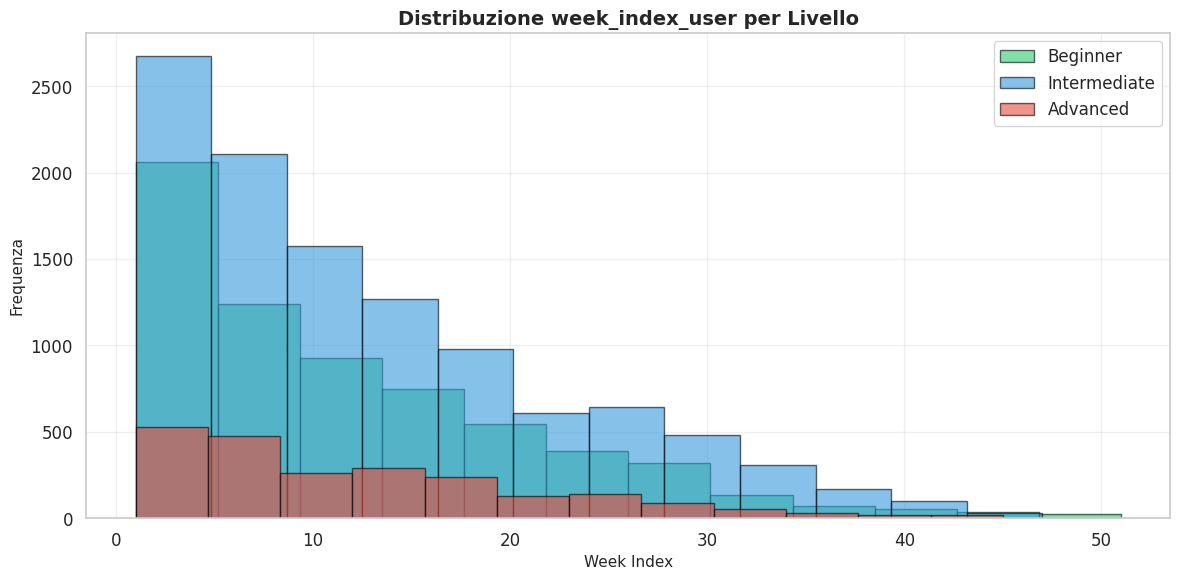

In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 12. ANALISI TEMPORALE (DISCUSSIONE)
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 11: FEATURE TEMPORALI - ANALISI E CONSIDERAZIONI")
print("="*80)

if 'week_index_user' in df_workouts.columns:
    # Statistiche per livello
    week_stats = df_wk_analysis.groupby('experience_label')['week_index_user'].agg([
        'min', 'max', 'mean', 'std'
    ])

    print("\nDistribuzione week_index_user per Livello:")
    print(week_stats.round(2).to_string())

    # Correlazione week_index vs experience (problematica)
    week_level_corr = df_wk_analysis[['week_index_user', 'experience_label']].copy()
    week_level_corr['target_encoded'] = week_level_corr['experience_label'].map(experience_map)
    corr_week = week_level_corr[['week_index_user', 'target_encoded']].corr().iloc[0, 1]

    print(f"\nCorrelazione week_index_user vs target: {corr_week:.3f}")

    print("\nCONSIDERAZIONI:")
    print("  - Feature temporali (week_index_user) mostrano correlazione con target")
    print("  - RISCHIO: Data leakage temporale")
    print("  - Nel dataset sintetico, Advanced hanno sempre week_index elevato")
    print("    (simulazione 12 settimane vs 4-8 settimane per Beginner)")
    print("  - In produzione: app non conosce 'da quanto tempo ti alleni'")
    print("  - DECISIONE: Esclusa dal modello finale per evitare overfitting")

    # Visualizzazione
    fig, ax = plt.subplots(figsize=(12, 6))
    for level in ['Beginner', 'Intermediate', 'Advanced']:
        data = df_wk_analysis[df_wk_analysis['experience_label'] == level]['week_index_user']
        ax.hist(data, bins=12, alpha=0.6, label=level,
                color=LEVEL_COLORS[level], edgecolor='black')

    ax.set_title('Distribuzione week_index_user per Livello',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Week Index', fontsize=11)
    ax.set_ylabel('Frequenza', fontsize=11)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



---

# SEZIONE 13: Analisi per Esercizio

---



SEZIONE 12: ANALISI PER TIPO ESERCIZIO

Top 10 Esercizi per Carico Medio:
                   count   mean    std    min     max
name                                                 
Squat              13381  55.35  19.74  18.25  131.25
Romanian Deadlift  12743  54.03  19.90  17.50  146.75
Incline DB Press   11985  48.61  17.96  16.50  162.25
Barbell Row        12969  47.96  17.65  18.00  135.75
Leg Press          11654  47.08  18.37  15.50  136.50
Bench Press        11755  46.20  18.12  17.25  157.25
Cable Fly           8054  36.73  13.53  10.50  100.75
Lat Pulldown        9720  35.74  13.28  11.75   88.25
Seated Cable Row   10241  35.70  13.24  12.50   86.25
Leg Curl            8885  35.65  13.81  12.00  103.00


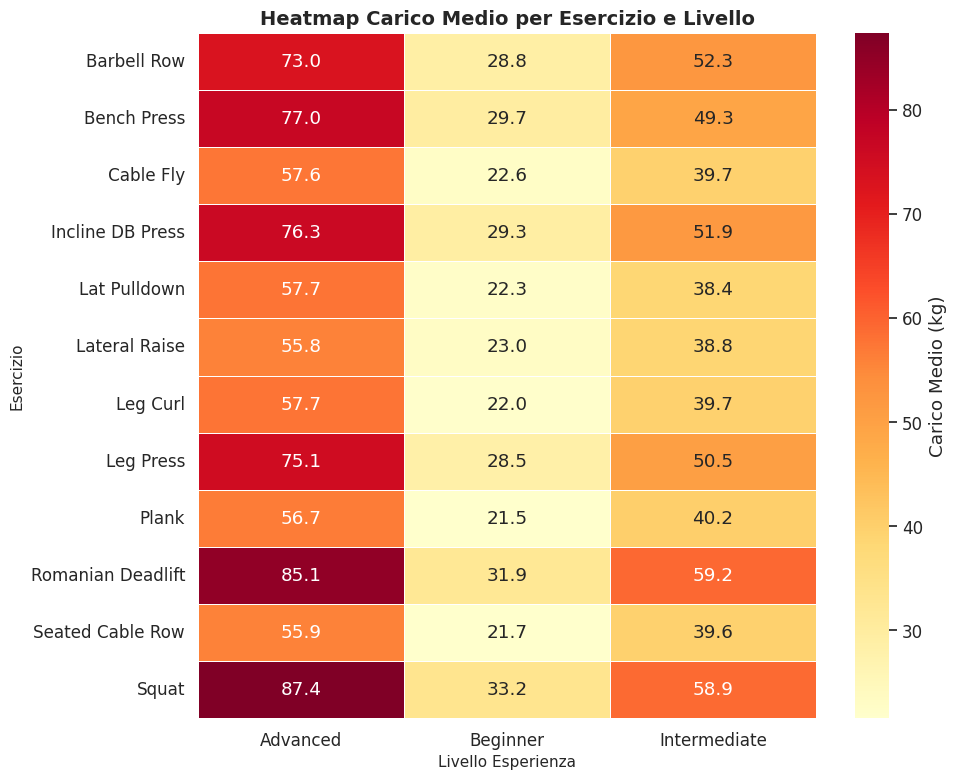

In [ ]:


# ═══════════════════════════════════════════════════════════════════════════
# 13. STATISTICHE PER ESERCIZIO
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 12: ANALISI PER TIPO ESERCIZIO")
print("="*80)

# Merge con catalogo esercizi
df_ex_analysis = df_analysis.merge(df_exercises[['exerciseid', 'name']],
                                     left_on='exerciseid',
                                     right_on='exerciseid',
                                     how='left')

# Top esercizi per carico medio
top_exercises_load = df_ex_analysis.groupby('name')['load_done_kg'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).sort_values('mean', ascending=False).head(10)

print("\nTop 10 Esercizi per Carico Medio:")
print(top_exercises_load.round(2).to_string())

# Heatmap carico medio per esercizio e livello
pivot_exercise = df_ex_analysis.pivot_table(
    values='load_done_kg',
    index='name',
    columns='experience_label',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot_exercise, annot=True, fmt='.1f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={"label": "Carico Medio (kg)"},
            ax=ax)
ax.set_title('Heatmap Carico Medio per Esercizio e Livello',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Livello Esperienza', fontsize=11)
ax.set_ylabel('Esercizio', fontsize=11)
plt.tight_layout()
plt.show()


---

# SEZIONE 14: Conclusioni

---


In [ ]:

# ═══════════════════════════════════════════════════════════════════════════
# 14. CONCLUSIONI E RIEPILOGO
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SEZIONE 13: CONCLUSIONI ANALISI ESPLORATIVA")
print("="*80)

print("""
RIEPILOGO ANALISI EDA
═════════════════════════════════════════════════════════════════════════════

1. QUALITA' DATI
   - Missing values: < 1% (accettabile, realistico)
   - Outliers: controllati (< 15% per feature)
   - Dataset dimensioni: 300 utenti, 550k set, 45k sessioni

2. TARGET (experience_label)
   - Distribuzione: Beginner 35%, Intermediate 55%, Advanced 10%
   - Imbalance ratio: < 3:1 (accettabile)
   - Rappresentazione realistica popolazione fitness

3. FEATURE PERFORMANCE (osservabili)
   - load_done_kg: Separazione FORTE tra livelli (ratio Adv/Beg: ~1.8x)
   - rpe_done: Separazione MEDIA (Advanced RPE inferiore)
   - reps_done: Distribuzione simile tra livelli
   - Test ANOVA: differenze statisticamente significative (p < 0.05)

4. CORRELAZIONI
   - load_mean, load_max: correlazione FORTE con target (r > 0.5)
   - volume (reps_total, sets_total): correlazione MEDIA (r ~ 0.4)
   - rpe_mean: correlazione DEBOLE negativa (r ~ -0.2)
   - Feature altamente correlate tra loro (multicollinearita' moderata)

5. COMPORTAMENTO
   - Skip rate Beginner (20%) > Intermediate (13%) > Advanced (6%)
   - Test Chi-quadrato: dipendenza significativa (p < 0.05)
   - Aderenza allenamento discriminante per livello

6. FEATURE ESCLUSE
   - Parametri latenti: non osservabili in produzione
   - Piano allenamento (load_intended, ecc.): rischio leakage
   - week_index_user: leakage temporale (esclusa da modello)

═════════════════════════════════════════════════════════════════════════════
RACCOMANDAZIONI PER FEATURE ENGINEERING
═════════════════════════════════════════════════════════════════════════════

1. FEATURE PRIORITARIE
   → load_mean, load_max (performance fisica)
   → skip_rate (comportamento)
   → volume_total = sets_total × reps_mean (carico lavoro)
   → sessions_per_week (frequenza)

2. FEATURE DERIVATE
   → load_std / load_mean (coefficiente variazione - consistenza)
   → rpe_mean × volume (intensita' percepita totale)
   → load_progression (trend temporale, se disponibile)

3. ENCODING
   → Target: ordinale {Beginner: 0, Intermediate: 1, Advanced: 2}
   → Categoriche: one-hot encoding (exercise_id, session_tag)

4. PREPROCESSING
   → Scaling: StandardScaler o MinMaxScaler
   → Train/test split: stratified (preserva distribuzione target)
   → Cross-validation: 5-fold stratified

═════════════════════════════════════════════════════════════════════════════
PROSSIMI PASSI
═════════════════════════════════════════════════════════════════════════════

1. Feature Engineering: aggregazioni e feature derivate
2. Feature Selection: rimozione ridondanze, importanza
3. Modeling: Random Forest, XGBoost, SVM
4. Evaluation: F1-score macro, confusion matrix
5. Interpretability: SHAP values, feature importance

═════════════════════════════════════════════════════════════════════════════
""")

print("="*80)
print("ANALISI ESPLORATIVA COMPLETATA")
print("="*80)



SEZIONE 13: CONCLUSIONI ANALISI ESPLORATIVA

RIEPILOGO ANALISI EDA
═════════════════════════════════════════════════════════════════════════════

1. QUALITA' DATI
   - Missing values: < 1% (accettabile, realistico)
   - Outliers: controllati (< 15% per feature)
   - Dataset dimensioni: 300 utenti, 550k set, 45k sessioni

2. TARGET (experience_label)
   - Distribuzione: Beginner 35%, Intermediate 55%, Advanced 10%
   - Imbalance ratio: < 3:1 (accettabile)
   - Rappresentazione realistica popolazione fitness

3. FEATURE PERFORMANCE (osservabili)
   - load_done_kg: Separazione FORTE tra livelli (ratio Adv/Beg: ~1.8x)
   - rpe_done: Separazione MEDIA (Advanced RPE inferiore)
   - reps_done: Distribuzione simile tra livelli
   - Test ANOVA: differenze statisticamente significative (p < 0.05)

4. CORRELAZIONI
   - load_mean, load_max: correlazione FORTE con target (r > 0.5)
   - volume (reps_total, sets_total): correlazione MEDIA (r ~ 0.4)
   - rpe_mean: correlazione DEBOLE negativa (r ~ -0